# Import and Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install torchmetrics

In [ ]:
%matplotlib inline
import sys
from pycocotools.coco import COCO
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import os
import skimage
import skimage.io as io
import copy
import torch
import cv2
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from torchvision import transforms
from PIL import Image
import csv
from numpy.random import shuffle
from torchvision import tv_tensors
import torchvision
import torchmetrics

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms import v2 as T
from torchvision.transforms.v2 import functional as F
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

import matplotlib.pyplot as plt

from torchmetrics.detection import MeanAveragePrecision

from matplotlib.cm import datad
from operator import index

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#device = torch.device('cpu')

# **Preparing Data**

In [ ]:
class PrepareDataTACO:
    def __init__(self):
      self.train_split = 0.8  # Ratio training split
      self.test_split = 0.1  # Ratio test split
      self.val_split = 0.1  # Ratio validation split

    def __call__(self, filename):
      # read json file
      with open(filename, "r") as json_file:
        data = json.load(json_file)

      # lengths of each split
      total_length = len(data)
      train_length = int(total_length * self.train_split)+1
      test_length = int(total_length * self.val_split)#+1
      val_length = int(total_length * self.test_split)#+1

      print(total_length, train_length, test_length, val_length)

      # random split for train, test, validation sets
      train_data, val_data, test_data = torch.utils.data.random_split(data, [train_length, val_length, test_length])

      train_set = []
      for data in train_data:
        train_set.append(data)

      val_set = []
      for data in val_data:
        val_set.append(data)

      test_set = []
      for data in test_data:
        test_set.append(data)

      return train_set, val_set, test_set


class PrepareDataMJU:
    def __init__(self):
      self.train_split = 0.8  # Ratio training split
      self.test_split = 0.1  # Ratio test split
      self.val_split = 0.1  # Ratio validation split

    def __call__(self, filename):
      # read json file
      with open(filename, "r") as json_file:
        data = json.load(json_file)

      print(data[0])

      return data


################ DEFINE THE CUSTOM DATASET GENERATORS ##########################################

class CustomDatasetTACO(Dataset):
    def __init__(self, data):
        self.data = data
        self.transform = transforms.ToTensor()

    def __len__(self):
        return len(self.data)

    def masks_to_boxes(self, masks):
        boxes = []
        for mask in masks:
            non_zero_coords = torch.nonzero(mask)
            #print(non_zero_coords)
            if non_zero_coords.size(0) > 0:
                min_coords = torch.min(non_zero_coords, dim=0).values
                max_coords = torch.max(non_zero_coords, dim=0).values
                #print('PRIMA', min_coords, max_coords)
                min_coords = torch.flip(min_coords, dims=[0])
                max_coords = torch.flip(max_coords, dims=[0])
                #print('DOPO', min_coords, max_coords)
                if min_coords[0]<max_coords[0] and min_coords[1]<max_coords[1]:
                  box = torch.cat([min_coords, max_coords], dim=0)
                  boxes.append(box)
                else:
                  #print(mask)
                  print(min_coords, max_coords)
                  boxes.append(torch.tensor([100, 200, 150, 250]))
            else:
                # If no non-zero coordinates, empty box
                boxes.append(torch.zeros(4))

        # list of boxes ---> tensor
        boxes = torch.stack(boxes)
        return boxes


    def __getitem__(self, idx):
        sample = self.data[idx]

        # find and read the image
        img_name = sample['filename']
        img_path = '/content/drive/MyDrive/VISIOPE_Project/DATASET/TACO_MJU/TACO_MJU_Images/'+img_name
        png_image = read_image(img_path)
        tensor_img = tv_tensors.Image(png_image)  #self.transform_img(png_image)

        # find, read and transform the image of the MASK
        for mask in os.listdir('/content/drive/MyDrive/VISIOPE_Project/DATASET/TACO_MJU/masks_unique/new/'):
          if img_name[:-4] in mask:
            #print(mask)
            mask_path = '/content/drive/MyDrive/VISIOPE_Project/DATASET/TACO_MJU/masks_unique/new/'+mask
            mask_image = read_image(mask_path)

            # find the different objects in the image mask
            obj_ids = torch.unique(mask_image)
            # remove the background from the count
            obj_ids = obj_ids[1:]
            num_objs = len(obj_ids)

            # create a mask (binary numpy array) for each object found
            masks = []
            for i in obj_ids:
              #print(int(i))
              m = (mask_image.numpy()[0, :, :] == int(i))
              m = self.transform(m).to(dtype=torch.uint8)
              #print(m.size())
              masks.append(m)
        #print(type(masks))

        tensor_masks = torch.cat(masks, dim=0)

        # create bounding box coordinates for each mask
        boxes = self.masks_to_boxes(tensor_masks)

        # create the labels (there is only one class) --> object
        labels = torch.ones((num_objs,), dtype=torch.int64)

        # calculate the area of the bounding boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["masks"] = tv_tensors.Mask(tensor_masks)
        target["labels"] = labels
        target["image_id"] = sample['id']

        return tensor_img.float()/255.0, target #or array []



class CustomDatasetMJU(Dataset):
    def __init__(self, data):
        self.data = data
        self.transform = transforms.ToTensor()

    def __len__(self):
        return len(self.data)

    def masks_to_boxes(self, masks):
        boxes = []
        for mask in masks:
            non_zero_coords = torch.nonzero(mask)
            #print(non_zero_coords)
            if non_zero_coords.size(0) > 0:
                min_coords = torch.min(non_zero_coords, dim=0).values
                max_coords = torch.max(non_zero_coords, dim=0).values
                #print('PRIMA', min_coords, max_coords)
                min_coords = torch.flip(min_coords, dims=[0])
                max_coords = torch.flip(max_coords, dims=[0])
                #print('DOPO', min_coords, max_coords)
                if min_coords[0]<max_coords[0] and min_coords[1]<max_coords[1]:
                  box = torch.cat([min_coords, max_coords], dim=0)
                  boxes.append(box)
                else:
                  #print(mask)
                  print(min_coords, max_coords)
                  boxes.append(torch.tensor([100, 200, 150, 250]))
            else:
                # If no non-zero coordinates, empty box
                boxes.append(torch.zeros(4))

        # list of boxes ---> tensor
        boxes = torch.stack(boxes)
        return boxes

    def __getitem__(self, idx):
        sample = self.data[idx]

        # find and read the image
        img_name = sample['filename']
        img_path = '/content/drive/MyDrive/VISIOPE_Project/DATASET/MJU/PNGImages/'+img_name
        png_image = read_image(img_path)
        tensor_img = tv_tensors.Image(png_image)

        # find, read and transform the image of the MASK
         for mask in os.listdir('/content/drive/MyDrive/VISIOPE_Project/DATASET/MJU/SegmentationClass/'):
          if img_name[:-4] in mask:
            #print(mask)
            mask_path = '/content/drive/MyDrive/VISIOPE_Project/DATASET/MJU/SegmentationClass/'+mask
            mask_image = read_image(mask_path)

            # find the different objects in the image mask
            obj_ids = torch.unique(mask_image)
            # remove the background from the count
            obj_ids = obj_ids[1:]
            num_objs = len(obj_ids)

            # create a mask (binary numpy array) for each object found
            masks = []
            for i in obj_ids:
              #print(int(i))
              m = (mask_image.numpy()[0, :, :] == int(i))
              m = self.transform(m).to(dtype=torch.uint8)
              #print(m.size())
              masks.append(m)
        #print(type(masks))

        tensor_masks = torch.cat(masks, dim=0)

        # create bounding box coordinates for each mask
        boxes = self.masks_to_boxes(tensor_masks)

        # create the labels (there is only one class) --> object
        labels = torch.ones((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["masks"] = tv_tensors.Mask(tensor_masks)
        target["labels"] = labels
        target["image_id"] = sample['id']

        return tensor_img.float()/255.0, target

In [ ]:
dataset = PrepareDataMJU()

#train_set, val_set, test_set = dataset('/content/drive/MyDrive/VISIOPE_Project/DATASET/TACO_MJU/only_taco.json')

train_set = dataset('/content/drive/MyDrive/VISIOPE_Project/DATASET/MJU/annotations_train.json')  #'/content/drive/MyDrive/VISIOPE_Project/DATASET/TACO_MJU/only_taco.json'
val_set = dataset('/content/drive/MyDrive/VISIOPE_Project/DATASET/MJU/annotations_val.json')
test_set = dataset('/content/drive/MyDrive/VISIOPE_Project/DATASET/MJU/annotations_test.json')


{'id': 0, 'filename': '2019-09-19_16_19_32-29_color.png', 'width': 640, 'height': 480, 'seg': [318.11, 188.75, 332.25, 324.48, 414.96, 315.99, 395.17, 180.27, 318.11, 188.04], 'area': 11013.695949999998, 'bbox': [450, 255, 137, 204], 'category_id': 0, 'iscrowd': 0}
{'id': 0, 'filename': '2019-09-19_16_20_17-93_color.png', 'width': 640, 'height': 480, 'seg': [283.48, 168.25, 284.89, 181.68, 273.58, 200.06, 267.22, 217.03, 279.23, 220.56, 284.89, 230.46, 279.94, 231.87, 284.89, 236.82, 287.72, 244.59, 279.94, 248.13, 286.3, 253.78, 274.29, 260.85, 277.82, 268.63, 274.29, 270.75, 282.06, 279.94, 322.36, 277.82, 328.01, 264.39, 325.18, 242.47, 320.24, 200.77, 299.03, 180.97, 301.86, 167.54, 284.89, 168.95], 'area': 4384.2052999999905, 'bbox': [378, 237, 86, 159], 'category_id': 0, 'iscrowd': 0}
{'id': 0, 'filename': '2019-09-19_16_19_49-57_color.png', 'width': 640, 'height': 480, 'seg': [270.04, 174.61, 306.8, 171.08, 312.46, 162.59, 347.1, 164.71, 351.34, 168.95, 369.72, 160.47, 392.34, 1

In [ ]:
def collate(batch):
  return tuple(zip(*batch))

train_data = CustomDatasetMJU(train_set)
train_loader = DataLoader(train_data, batch_size = 4, shuffle=True, collate_fn=collate, pin_memory=False)

val_data = CustomDatasetMJU(val_set)
val_loader = DataLoader(val_data, batch_size = 4, shuffle=False, collate_fn=collate, pin_memory=False)

test_data = CustomDatasetMJU(test_set)
test_loader = DataLoader(test_data, batch_size = 4, shuffle=False, collate_fn=collate, pin_memory=False)

# **Model and Training**

In [ ]:
def get_model(num_classes):
    # load the instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # change the pre-trained head the FastRCNNPredictor
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # get the number of input features for mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # change the mask predictor with the MaskRCNNPredictor
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes,
    )

    return model

In [ ]:
def mAP(outputs, target, len_batch):
  IoU = []
  for i in range(len_batch):
      mask_pred = outputs[i]['masks']
      mask_true = targets[i]['masks']

      len_true = torch.sum(mask_true == 1).item()
      len_pred = torch.sum(mask_pred > 0.8).item()
      len_one = torch.sum((mask_true == 1) & (mask_pred > 0.8)).item()
      #print(len_true, len_one)
      IoU.append(len_one/((len_true+len_pred)-len_one))
  return IoU

In [ ]:
# our dataset has two classes only - background and objects
num_classes = 2
cpu_device = torch.device('cpu')

# get the model
model = get_mode(num_classes)
# move model to device
model.to(device)

# construct the optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

map = []

##### TRAINING PART #####
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(train_loader) - 1)
        lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=warmup_iters)

    for inputs, targets in train_loader:
        #print(targets)
        # Move images and targets in batch to device
        images = list(image.to(device) for image in inputs)
        targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]
        # during training the MaskRCNN model returns a dict as prediction
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        if lr_scheduler is not None: lr_scheduler.step()

    # Val step
    model.eval()
    for inputs, targets in val_loader:
        images = list(image.to(device) for image in inputs)
        #outputs = model(images)
        outputs = model(images)
        outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
        #print(outputs[0])
        IoU = mAP(outputs, targets, len(outputs))

    map.append(np.mean(IoU))

    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {losses:.4f}, Map: {np.mean(IoU)}")

print("That's it!")

model_path = '/content/drive/MyDrive/VISIOPE_Project/weights/MASKrcnn_MJU_5epochs_batch4'
torch.save(model.state_dict(), model_path)

Output streaming troncato alle ultime 5000 righe.
          [0.1981, 0.2160, 0.2339,  ..., 0.2518, 0.2339, 0.2160],
          [0.2266, 0.2470, 0.2675,  ..., 0.2879, 0.2675, 0.2470],
          ...,
          [0.3403, 0.3711, 0.4018,  ..., 0.4325, 0.4018, 0.3711],
          [0.3119, 0.3401, 0.3682,  ..., 0.3963, 0.3682, 0.3401],
          [0.2835, 0.3090, 0.3346,  ..., 0.3602, 0.3346, 0.3090]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.9809, 0.9849, 0.9650,  ..., 0.0000, 0.0000, 0.0000]]]],
       grad_fn=<ToCopyBackward0>)}
4
4
{'boxes': tensor([[  0.0000,   2.4042, 640.0000, 480.0000],
        [  0.0000, 479.9893,   3.3930, 480.0000]], grad_fn=<ToCopyBackward0>), 'labels':

# test

In [ ]:
from torchvision.utils import draw_bounding_boxes

In [ ]:
#TO LOAD THE PREVIOUS SAVED MODEL
model_path = '/content/drive/MyDrive/VISIOPE_Project/weights/MASKrcnn_MJU_5epochs_batch4'

# Define the model
model_test = get_model(2)  # Replace with the actual model you've defined

# Load the model's state
model_test.load_state_dict(torch.load(model_path))

model_test.to(device)

# Put the model in evaluation mode if necessary
model_test.eval()


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [ ]:
model_test.eval()
cpu_device = torch.device('cpu')

IoU = []
#validation_data = []
#metric = MeanAveragePrecision(iou_type="bbox")

for inputs, targets in val_loader:
    images = list(image.to(device) for image in inputs)
    #print(len(images))
    outputs = model_test(images)
    outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
    #print(outputs)
    #print(targets)
    #validation_data.append([outputs, targets])

    #metric.update(outputs, targets)
    for i in range(4):
      mask_pred = outputs[i]['masks']
      mask_true = targets[i]['masks']
      # print(mask_pred)
      # print(mask_true)

      len_true = torch.sum(mask_true == 1).item()
      #print(len_true)
      len_one = torch.sum((mask_true == 1) & (mask_pred > 0.8)).item()
      print(len_true, len_one)
      IoU.append(len_one/len_true)


torch.Size([1, 3, 3120, 4160])
[{'boxes': tensor([[   0.,    0., 4160., 3120.]], device='cuda:0',
       grad_fn=<StackBackward0>), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9999], device='cuda:0', grad_fn=<IndexBackward0>), 'masks': tensor([[[[0.2496, 0.2530, 0.2564,  ..., 0.2602, 0.2568, 0.2534],
          [0.2541, 0.2575, 0.2610,  ..., 0.2648, 0.2614, 0.2580],
          [0.2586, 0.2621, 0.2656,  ..., 0.2695, 0.2660, 0.2625],
          ...,
          [0.2634, 0.2670, 0.2705,  ..., 0.2742, 0.2706, 0.2671],
          [0.2590, 0.2624, 0.2659,  ..., 0.2695, 0.2660, 0.2625],
          [0.2545, 0.2579, 0.2613,  ..., 0.2648, 0.2614, 0.2580]]]],
       device='cuda:0', grad_fn=<UnsqueezeBackward0>)}]


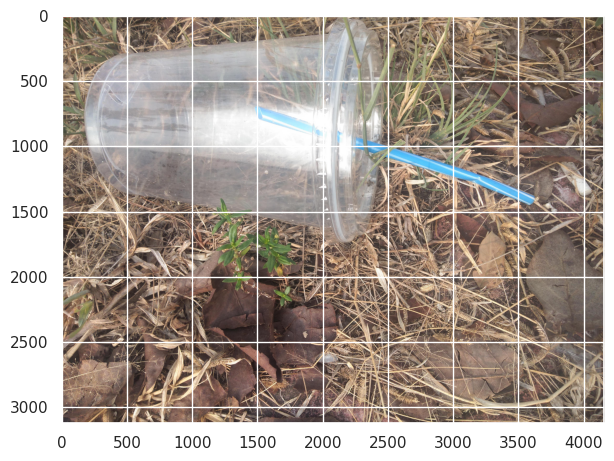

In [ ]:
img_path = '/content/drive/MyDrive/VISIOPE_Project/DATASET/TACO/batch_13/000010.jpg' #/content/drive/MyDrive/VISIOPE_Project/DATASET/MJU/PNGImages/'+ test_set[20]['filename']
png_image = read_image(img_path).float()/255.0
tensor_image = png_image.unsqueeze(0).to(device)
print(tensor_image.size())
output = model_test(tensor_image)
print(output)
output = output[0]
pred_boxes = output["boxes"].long()

pred_labels = []
for label, score in zip(output["labels"], output["scores"]):
  if score >= 0.4:
    pred_labels.append(f"trash: {score:.3f}")

pred_boxes = output["boxes"][:len(pred_labels)].long()
image = (255.0 * (png_image - png_image.min()) / (png_image.max() - png_image.min())).to(torch.uint8)
image = image[:3, ...]

output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

plt.figure(figsize=(7, 7))
plt.imshow(output_image.permute(1, 2, 0))
